In [23]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/mutation.py
%run ../Scripts/initMethods.py
%run ../Scripts/formulas.py
%run ../Scripts/entropy.py

In [2]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":          100000,
    "M":                1, #Also L, total number of spacers
    "mu":               1, #mutation rate
    "gamma_shape":     20, 
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    100,
    "dx":                           1,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_var_n":               10,
    "num_threads":                  4,
}

In [3]:
n = init_guassian(params["N0"], sim_params, "n")
n_new = mutation(n, params, sim_params)
xdomain = sim_params["xdomain"]
dx = sim_params["dx"]
xspace = np.arange(-xdomain, xdomain, dx )

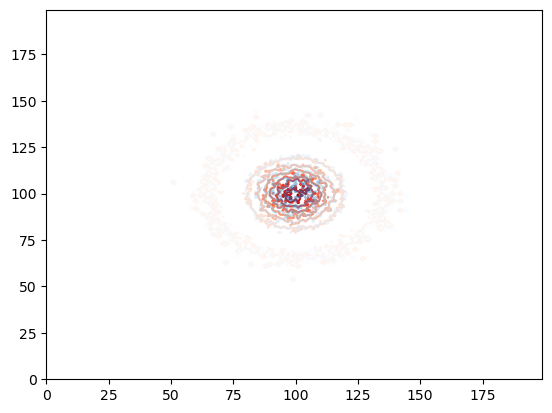

In [6]:
plt.contour(n.todense(), cmap = "Reds")
plt.contour(n_new.todense(), cmap = "Blues", alpha = 0.5)

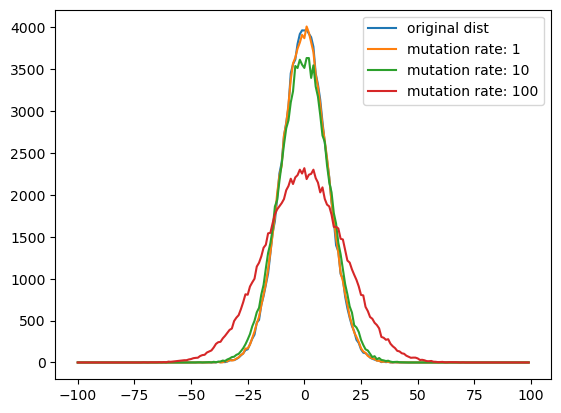

In [7]:
n = init_guassian(params["N0"], sim_params, "n")
flat_n = np.array(np.sum(n.todense(), axis=0)).squeeze()
plt.plot(xspace, flat_n, label = "original dist")
for i in [1, 10, 100]:
    params["mu"] = i
    n_new = mutation(n, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    plt.plot(xspace, flat_n_new, label=f"mutation rate: {i}")
plt.legend()

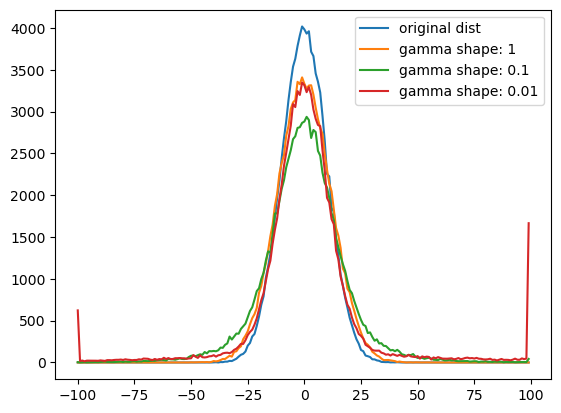

In [8]:
n = init_guassian(params["N0"], sim_params, "n")
params["mu"] = 10

flat_n = np.array(np.sum(n.todense(), axis=0)).squeeze()
plt.plot(xspace, flat_n, label = "original dist")
for i in [1, 1/10, 1/100]:
    params["gamma_shape"] = i
    n_new = mutation(n, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    plt.plot(xspace, flat_n_new, label=f"gamma shape: {i}")
plt.legend()

In [30]:
%run ../Scripts/entropy.py

params["mu"] = mu = 10
params["gamma_shape"]= 0.5

In [25]:
def entropy_simulation(params, sim_params, t = 20, to_plot = False):
    n_old = init_guassian(params["N0"], sim_params, "n")
    n_new = mutation(n_old, params, sim_params)
    xdomain = sim_params["xdomain"]
    dx = sim_params["dx"]
    xspace = np.arange(-xdomain, xdomain, dx )
    
    entropy_change = np.zeros(t)
    entropy = np.zeros(t)
    entropy_guassian = np.zeros(t)

    N = params["N0"]
    if to_plot:
        plt.figure()

    for i in range(1, t):
        func = params["N0"]*guassian_diffusion(xspace, xspace, i, params, sim_params)
        flat_func = np.sum(func, axis = 0)

        n_new = mutation(n_old, params, sim_params)
        flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()

        if i%5 ==0 and to_plot:
            plt.plot(xspace, flat_func, alpha = 0.3)
            plt.plot(xspace, flat_n_new, label = f"time = {i}")

        entropy[i] = compute_entropy(n_new)
        entropy_change[i] = compute_entropy_change(n_new, n_old)
        entropy_guassian[i] = compute_entropy(func)
        n_old = n_new

    if to_plot:
        plt.legend()
        plt.show()
    return entropy_change, entropy, entropy_guassian

In [26]:
diff_consts = []
entropies = []
params["gamma_shape"] = 20
sim_params["xdomain"] = 1000

for mu in [0.01, 0.1 , 1]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])

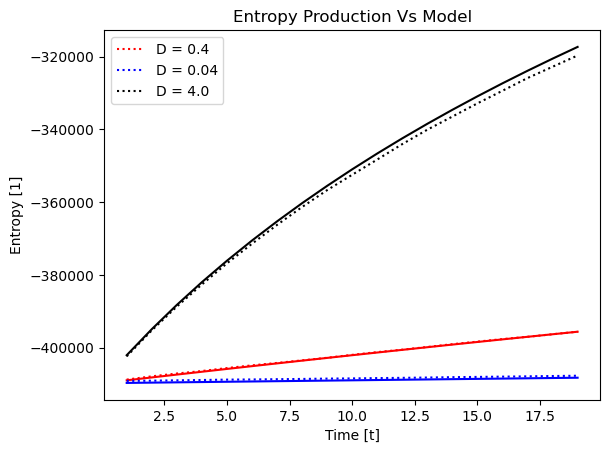

In [37]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']

for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range, entropy[0][1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_Gaussian(var**2, diff_const, t_range,N = N)-2800, color = color)
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.title("Entropy Vs Model")
plt.legend()
plt.show()

In [34]:
diff_consts = []
entropies = []
params["gamma_shape"] = 0.2
sim_params["xdomain"] = 1000

for mu in [0.1, 1 , 10]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])

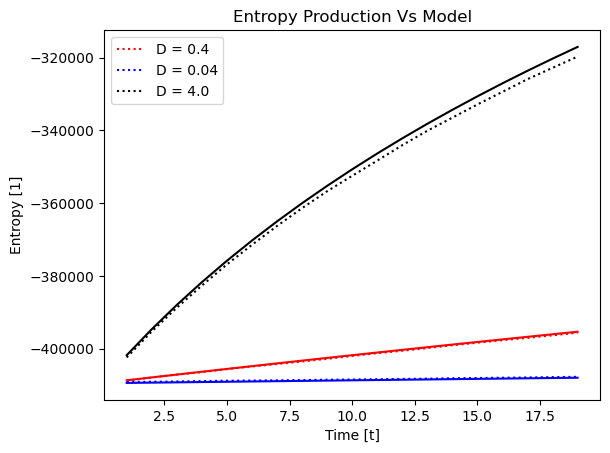

In [36]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']

for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range, entropy[0][1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_Gaussian(var**2, diff_const, t_range,N = N)-2500, color = color)
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.title("Entropy Vs Model")
plt.legend()
plt.show()

In [ ]:
variances = []
entropies = []
params["mu"] = 1
params["gamma_shape"]=20

for var in [5, 10, 100]:
    params["init_var_n"] = var
    variances.append(var)
    entropies.append(entropy_simulation(params, sim_params, to_plot = True))

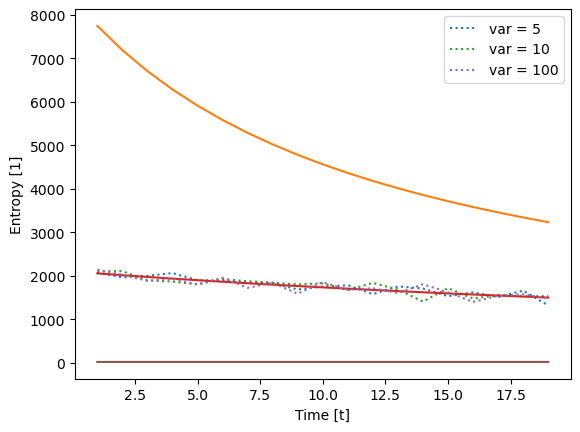

In [32]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]
diff_const = calc_diff_const(params, sim_params)

for var, entropy_change in zip(variances, entropies):
    plt.plot(t_range, entropy_change[1:], label = f"var = {var}",linestyle = "dotted", linewidth = 1.5)
    plt.plot(t_range, N*entropy_production_mutation(var**2, diff_const,t_range))
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.legend()
plt.show()